In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece as spm
import numpy as np
import re
import konlpy
from collections import Counter

In [100]:
korean_train_data = []
english_train_data = []
korean_test_data = []
english_test_data = []

with open("./korean-english-park.train.ko", "r") as f:
    korean_train_data = f.read().splitlines()

with open("./korean-english-park.train.en", "r") as f:
    english_train_data = f.read().splitlines()
    
with open("./korean-english-park.test.ko", "r") as f:
    korean_test_data = f.read().splitlines()
    
with open("./korean-english-park.test.en", "r") as f:
    english_test_data = f.read().splitlines()

In [101]:
train_data = pd.DataFrame([i for i in zip(korean_train_data, english_train_data)], columns=["korean", "english"])
test_data = pd.DataFrame([i for i in zip(korean_test_data, english_test_data)], columns=["korean", "english"])
train_data 
test_data

,korean,english
0,토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을...,Those involved in the discussions do take seri...
1,"또한 새로운 기술 개발이 어떤 해결책을 제공해 주는데 도움이 될 것이고, 동시 에 ...",There is also some hope that new technology de...
2,그래서 클리퍼 칩에 대한 개인적인 해결책은 서서히 자취를 감출 것입니다. 그러나 이...,So the individual solution of the clipper chip...
3,이탈리아의 천문학자들이 멀리에 있는 별들의 궤도를 도는 행성의 대기에서 생명체의 필...,"Italian astronomers have found signs of water,..."
4,"물이 있다는 것이 다른 행성에 생명체들이 가득하다는 것을 의미하지는 않지만, 이번 ...",Having water does not mean other planets will ...
...,...,...
1995,코리아 헤럴드는 이번 관련법 개정으로 해외 부동산을 취득하고자 하는 개인에 대한 규...,The Korea Herald reports part of these changes...
1996,또한 투자 펀드를 통해 해외 부동산에 투자하고자 하는 사람들에게도 유리해지도록 법 ...,Other legal changes will help those aiming to ...
1997,"반 외교부장관, 최근 핵 문제 관련 북한 태도에 경고",Foreign minister Ban warned North Korea for it...
1998,"일본, 통근 열차 탈선 사고로 최소 69명 사망",Japan's derailed commuter train accident has k...


In [102]:
print(len(train_data[train_data.duplicated(["korean", "english"])]))
train_data = train_data.drop_duplicates(["korean", "english"], ignore_index=True)

print(len(test_data[test_data.duplicated(["korean", "english"])]))
test_data = test_data.drop_duplicates(["korean", "english"], ignore_index=True)

15155
4


In [103]:
train_data = train_data.sample(20000)

In [104]:
korean_corpus = train_data["korean"]
english_corpus = train_data["english"]

korean_text_corpus = test_data["korean"]
english_text_corpus = test_data["english"]

In [105]:
def preprocess(sentence, korean=True):
    sentence = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s.,?!\'\"]", "", sentence)
    sentence = re.sub("\"+", "", sentence)
    sentence = re.sub(r"\.+", " .", sentence)
    sentence = re.sub("!+", " !", sentence)
    sentence = re.sub("\?+", " ?", sentence)
    sentence.lower().strip()
    if not korean:
        sentence = "<sos> " + sentence + " <eos>"
    
    return sentence

In [106]:
korean_corpus = [preprocess(sentence, korean=True) for sentence in korean_corpus]
english_corpus = [preprocess(sentence, korean=False) for sentence in english_corpus]

korean_text_corpus = [preprocess(sentence, korean=True) for sentence in korean_text_corpus]
english_text_corpus = [preprocess(sentence, korean=False) for sentence in english_text_corpus]

In [108]:
def konlpy_tokenizer(tokenizer, corpus):
    words = []
    sentences = []
    for c in corpus:
        temp = tokenizer.morphs(c)
        words += temp
        sentences.append(temp)
        
    counter = Counter(words)
    counter = counter.most_common()
    
    words = ["<pad>", "<unk>"] + [key for key, _ in counter]
    word_to_index = {word : index for index, word in enumerate(words)}
    tensor = []
    
    for c in sentences:
        temp = []
        for s in c:
            if s in words:
                temp.append(word_to_index[s])
            else:
                temp.append(word_to_index["<unk>"])
        tensor.append(temp)
    
    return tensor, word_to_index

In [109]:
mecab = konlpy.tag.Mecab()
korean_tokens, korean_word_to_index = konlpy_tokenizer(mecab, korean_corpus)

30039


In [126]:
WORD_SIZE = len(korean_word_to_index)

In [110]:
korean_text_corpus = [mecab.morphs(k) for k in korean_text_corpus]
korean_test = []
for c in korean_text_corpus:
        temp = []
        for s in c:
            if s in korean_word_to_index:
                temp.append(korean_word_to_index[s])
            else:
                temp.append(korean_word_to_index["<unk>"])
        korean_test.append(temp)

In [127]:
korean_index_to_word = {word : index for word, index in enumerate(korean_word_to_index)}

In [128]:
english_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=" ")
english_tokenizer.fit_on_texts(english_corpus)
english_tokens = english_tokenizer.texts_to_sequences(english_corpus)
english_test = english_tokenizer.texts_to_sequences(english_text_corpus)
print(len(english_tokenizer.word_index))
print(WORD_SIZE)

37531
30039


In [129]:
encoder_input = []
decoder_input = []

for k, e in zip(korean_tokens, english_tokens):
    if len(e) < 40 and len(k) < 40:
        encoder_input.append(k)
        decoder_input.append(e)

In [130]:
print(len(encoder_input), len(decoder_input))

15451 15451


In [131]:
encoder_input = tf.keras.preprocessing.sequence.pad_sequences(encoder_input, padding='post')
decoder_input = tf.keras.preprocessing.sequence.pad_sequences(decoder_input, padding='post')

In [132]:
encoder_test = []
decoder_test = []

for k, e in zip(korean_test, english_test):
    if len(e) < 40 and len(k) < 40:
        encoder_test.append(k)
        decoder_test.append(e)

encoder_test = tf.keras.preprocessing.sequence.pad_sequences(encoder_test, padding='post')
decoder_test = tf.keras.preprocessing.sequence.pad_sequences(decoder_test, padding='post')

In [133]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [134]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(enc_units, return_sequences=True, dropout=0.3)
        self.gru2 = tf.keras.layers.GRU(enc_units, return_sequences=True, dropout=0.3)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru1(out)
        out = self.gru2(out)
        
        return out

In [135]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(dec_units, return_sequences=True, dropout=0.3)
        self.gru2 = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True, dropout=0.3)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out = self.gru1(out)
        out, h_dec = self.gru2(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [141]:
BATCH_SIZE = 256
SRC_VOCAB_SIZE = WORD_SIZE + 1
TGT_VOCAB_SIZE = len(english_tokenizer.word_index) + 1

units = 256
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

In [142]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [143]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index["<sos>"]] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [144]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index["<sos>"]] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [ ]:
loss = []

In [152]:
from tqdm import tqdm
import random

EPOCHS = 100

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, encoder_input.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)  

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(encoder_input[idx:idx+BATCH_SIZE],
                                decoder_input[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                english_tokenizer)
    
        total_loss += batch_loss
        loss.append((total_loss.numpy() / (batch + 1)))
        
        t.set_description_str('Epoch %2d' % (epoch + 1)) 
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    

Epoch 100: 100%|██████████| 61/61 [00:24<00:00,  2.45it/s, Loss 0.3866]


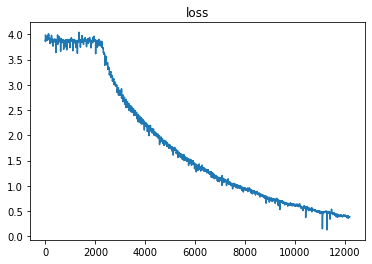

In [153]:
plt.plot(loss)
plt.title("loss")
plt.show()

In [170]:
def decode_sequence(input_sentence):
    input_sentence = preprocess(input_sentence)
    input_sentence = [korean_word_to_index[s] for s in mecab.morphs(input_sentence)]
    input_sentence = tf.keras.preprocessing.sequence.pad_sequences([input_sentence], padding="post", maxlen=39)
  
    states_value = encoder(input_sentence)
    
    decoder_hidden = states_value[:, -1]
    decoder_input = tf.expand_dims([english_tokenizer.word_index["<sos>"]], 0)
    
    flag = True
    decoded_sentence = ""
    while flag:
        output_tokens, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, states_value)

        sampled_token_index = tf.argmax(tf.math.softmax(output_tokens, axis=-1)[0]).numpy()
        sampled_token = english_tokenizer.index_word[sampled_token_index]

        decoded_sentence += " " + sampled_token

        if sampled_token == "<eos>" or len(decoded_sentence) > 39:
            flag = False
        decoder_input = tf.expand_dims([sampled_token_index], 0)

    return decoded_sentence[:-6]

In [203]:
print(decode_sequence("처음부터 시작"))
print(decode_sequence("전쟁이 발발하였습니다"))
print(decode_sequence("지구온난화가 심각하다고 주장했습니다"))

 for the next project
 one is a new trademark dispute .
 they had no longer the right for the ap
